## Assignment2 - Supervised Learning flow

### Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Matan 9719
# student 2: Ofek 3015
# student 3: shira 6768
# student 4: Omer 7908
# student 5: Seged 0418
# student 6: Gal 0798

## Part 2 - Experiments
You could add as many code cells as needed

In [2]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
# Load datasets
train_df = pd.read_csv('titanic_train.csv')
test_df = pd.read_csv('titanic_test.csv')

In [5]:
# Display the first 5 rows of each dataset
print("Train dataset:")
print(train_df.head())  # Display first 5 rows of the training dataset
print("\nTest dataset:")
print(test_df.head())  # Display first 5 rows of the test dataset

Train dataset:
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0

Test dataset:
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1



Statistics of the training data:
           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000   
mean     2.294944    0.640449   29.531213    0.528090    0.384831   32.379429   
std      0.841990    0.480206   13.188028    1.055052    0.803085   49.836074   
min      1.000000    0.000000    0.670000    0.000000    0.000000    0.000000   
25%      1.750000    0.000000   22.000000    0.000000    0.000000    7.925000   
50%      3.000000    1.000000   29.699118    0.000000    0.000000   14.500000   
75%      3.000000    1.000000   35.000000    1.000000    0.000000   31.275000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.329200   

         Embarked    Survived  
count  712.000000  712.000000  
mean     0.372191    0.394663  
std      0.649970    0.489122  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      1.0

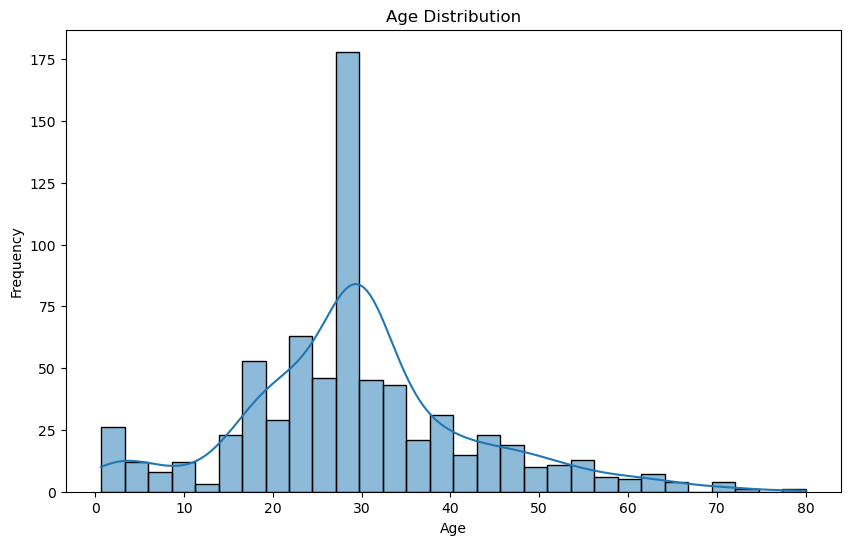

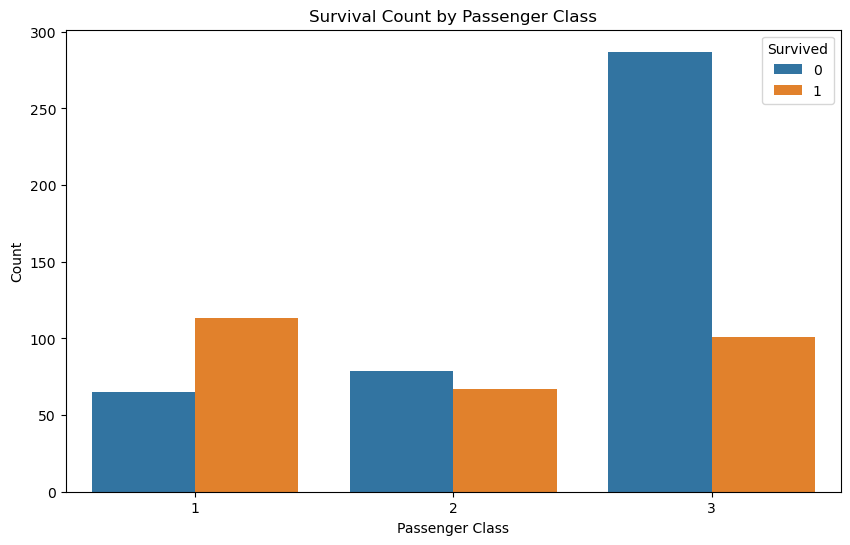

In [6]:
# EDA - presenting statistics and visualizations on the data

# Display basic statistics of the training data
print("\nStatistics of the training data:")
print(train_df.describe())

# Visualization 1: Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Survival count by passenger class
plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()

In [7]:
# Feature engineering

# Select relevant features for modeling
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
train_X = train_df[features].copy()
test_X = test_df[features].copy()

# Handle missing values in the 'Age' column using the median strategy
imputer = SimpleImputer(strategy='median')
train_X.loc[:, 'Age'] = imputer.fit_transform(train_X[['Age']])
test_X.loc[:, 'Age'] = imputer.transform(test_X[['Age']])

# Encode categorical data ('Sex' column) using one-hot encoding
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)

# Ensure both train and test sets have the same dummy variables
train_X, test_X = train_X.align(test_X, join='left', axis=1, fill_value=0)

# Scale numerical features ('Age' and 'Fare') using StandardScaler
scaler = StandardScaler()
train_X[['Age', 'Fare']] = scaler.fit_transform(train_X[['Age', 'Fare']])
test_X[['Age', 'Fare']] = scaler.transform(test_X[['Age', 'Fare']])

# Prepare the target variable
train_y = train_df['Survived']

In [8]:
# Training and hyperparameter tuning

# Define the models to be tested: Naive Bayes and K-Nearest Neighbors (KNN)
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'Naive Bayes': {},  # No hyperparameters for Naive Bayes
    'KNN': {
        'n_neighbors': [3, 5, 7],  # Different values for the number of neighbors
        'weights': ['uniform', 'distance']  # Different weighting strategies
    }
}

In [9]:
# Define the scorer for F1-macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Perform grid search with 5-fold cross-validation and find the best parameters
best_estimators = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring=f1_macro_scorer)
    grid_search.fit(train_X, train_y)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation F1 score for {model_name}: {grid_search.best_score_}")

# Comparison of results

# Compile results into a DataFrame for comparison
results = {
    'Model': [],
    'Best Params': [],
    'Best F1 Score': []
}
for model_name, estimator in best_estimators.items():
    results['Model'].append(model_name)
    results['Best Params'].append(estimator.get_params())
    results['Best F1 Score'].append(cross_val_score(estimator, train_X, train_y, cv=5, scoring=f1_macro_scorer).mean())

results_df = pd.DataFrame(results)
print("\nComparison of Results:")
print(results_df)

# Choosing the best model

# Identify the best model based on the highest F1 score
best_model_name = results_df.loc[results_df['Best F1 Score'].idxmax()]['Model']
best_model = best_estimators[best_model_name]
print(f"\nBest Model: {best_model_name} with params: {results_df.loc[results_df['Best F1 Score'].idxmax()]['Best Params']}")


Best parameters for Naive Bayes: {}
Best cross-validation F1 score for Naive Bayes: 0.7676379308344069

Best parameters for KNN: {'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation F1 score for KNN: 0.7747236994470564

Comparison of Results:
         Model                                        Best Params  \
0  Naive Bayes           {'priors': None, 'var_smoothing': 1e-09}   
1          KNN  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   

   Best F1 Score  
0       0.767638  
1       0.774724  

Best Model: KNN with params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


## Part 3 - Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 2)

In [10]:
# Part 3: Activating the flow according to the various parameters

# Train the best model using the entire training set
print("\nTraining the best model on the entire training set...")
best_model.fit(train_X, train_y)


Training the best model on the entire training set...


KNeighborsClassifier(n_neighbors=7, weights='distance')

## Part 4 - Apply on test and show model performance estimation

In [11]:
# Part 4: Running on the test set and evaluating the model

# Apply the same feature engineering steps to the test set and make predictions
test_X['Age'] = imputer.transform(test_X[['Age']])  # Handle missing values
test_X[['Age', 'Fare']] = scaler.transform(test_X[['Age', 'Fare']])  # Scale numerical features
test_X = pd.get_dummies(test_X)  # Encode categorical data

# Ensure both train and test sets have the same dummy variables
train_X, test_X = train_X.align(test_X, join='left', axis=1, fill_value=0)

# Make predictions using the best-trained model
predictions = best_model.predict(test_X)

# Show the first few classifications on the test set
print("\nFirst classifications on the test set:")
print(predictions[:10])

# Load the actual labels for the test set
test_labels_df = pd.read_csv('titanic_test.csv')
test_y = test_labels_df['Survived']

# Evaluate the model performance on the test set using F1 score
f1_score_test = f1_score(test_y, predictions, average='macro')
print(f"\nF1 Score on the test set: {f1_score_test}")


First classifications on the test set:
[0 0 0 1 0 1 1 0 1 0]

F1 Score on the test set: 0.773387526652452
